## Hive metastore

We made quite a few table declarations like this in the previous tutorial:

```parquetDf = sqlContext.read.parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet")
 parquetDf.createOrReplaceTempView("sireneparquet")```
 
The major drawback of this technique is that we do not save any metadata related to the existence of a `sireneparquet` table.
This metadata would allow multiple clients (Python, R, different users, or visualization tools) to all understand the context when accessing the `sireneparquet` table.

The goal of the Hive metastore is exactly this: to save the metadata of our tables present in different storage locations.


The service catalog allows you to start a Hive metastore.


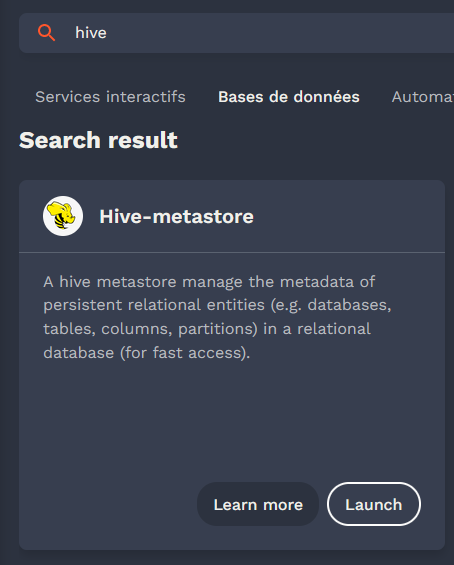

### Pré-requis

In [2]:
! cat /opt/hive/conf/hive-site.xml

<?xml version="1.0"?>
<?xml-stylesheet type="text/xsl" href="configuration.xsl"?>
<configuration>
<property>
    <name>hive.metastore.uris</name>
        <value>thrift://hive-metastore:9083</value>
    </property>
</configuration>


You should have a property like this in your environment.

```
<property>
    <name>hive.metastore.uris</name>
    <value>thrift://hive-metastore-1617799882:9083</value>
</property>
```

**If this is not the case, start the `hive-metastore` service and restart this tutorial from the Onyxia training interface.**


### Let's Go, Let's Create a Spark Configuration


In [3]:
import os
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
         .enableHiveSupport()
         .getOrCreate()
        )

sc = spark.sparkContext





From now on, we will be able to persist the metadata of our tables in the Hive metastore.
There are two main categories of tables:
* Managed (internal) tables
* External tables

The data of managed tables is controlled by Hive, which has full authority over the physical storage. When you delete a managed table, the data is also deleted from the warehouse directory. By default, the warehouse directory is "s3/your-bucket/hive-warehouse".

External tables point to data not controlled by Hive, such as CSV, JSON, or Parquet files that you have already stored in your data lake.
This is typically the case when data administrators publish data in a storage space accessible to a group of users.

#### Let's Go
I will try to register my existing external `sirene` table in the data lake in the Hive metastore.


In [4]:
spark.sql('show tables;').show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+



je n'ai enregistré aucune table encore

In [5]:
spark.sql('show databases;').show()

+---------+
|namespace|
+---------+
|  default|
+---------+



There is also the concept of databases, which we can ignore in this tutorial.


### Creating the Hive Table

Our goal is to declare a `sirene` table that points to data present in our data lake.
This declaration of a non-managed (external) Hive table uses the keywords `EXTERNAL` and `LOCATION`.
The syntax for our `sirene` table is as follows:


```CREATE EXTERNAL TABLE sirene (siren int,nic int,siret bigint,dateFin string,dateDebut string,etatAdministratifEtablissement string,changementEtatAdministratifEtablissement boolean,enseigne1Etablissement string,enseigne2Etablissement string,enseigne3Etablissement string,changementEnseigneEtablissement boolean,denominationUsuelleEtablissement string,changementDenominationUsuelleEtablissement boolean,activitePrincipaleEtablissement string,nomenclatureActivitePrincipaleEtablissement string,changementActivitePrincipaleEtablissement string,caractereEmployeurEtablissement string,changementCaractereEmployeurEtablissement string ) STORED as parquet LOCATION 's3a://projet-spark-lab/diffusion/formation/data/sirene-10-partitions.parquet```

To create this table, we can script the generation of the query using the schema of the sources, which the Parquet format directly provides. Here is an example of how to generate the `CREATE TABLE` statement:

In [6]:
from pyspark import SQLContext
df = spark.read.parquet("s3a://projet-spark-lab/diffusion/formation/data/sirene.parquet")
df.printSchema()
cols = df.dtypes
buf = []
buf.append('CREATE EXTERNAL TABLE IF NOT EXISTS sirene (')
keyanddatatypes =  df.dtypes
sizeof = len(df.dtypes)
count=1;
for eachvalue in keyanddatatypes:
    if count == sizeof:
        total = str(eachvalue[0])+str(' ')+str(eachvalue[1])
    else:
        total = str(eachvalue[0]) + str(' ') + str(eachvalue[1]) + str(',')
    buf.append(total)
    count = count + 1

buf.append(' )')
buf.append(' STORED as parquet ')
buf.append("LOCATION ")
buf.append("'")
buf.append('s3a://projet-spark-lab/diffusion/formation/data/sirene-10-partitions.parquet')
buf.append("'")

##partition by pt
tabledef = ''.join(buf)

print ("---------print definition ---------")
print (tabledef)

root
 |-- siren: integer (nullable = true)
 |-- nic: integer (nullable = true)
 |-- siret: long (nullable = true)
 |-- dateFin: string (nullable = true)
 |-- dateDebut: string (nullable = true)
 |-- etatAdministratifEtablissement: string (nullable = true)
 |-- changementEtatAdministratifEtablissement: boolean (nullable = true)
 |-- enseigne1Etablissement: string (nullable = true)
 |-- enseigne2Etablissement: string (nullable = true)
 |-- enseigne3Etablissement: string (nullable = true)
 |-- changementEnseigneEtablissement: boolean (nullable = true)
 |-- denominationUsuelleEtablissement: string (nullable = true)
 |-- changementDenominationUsuelleEtablissement: boolean (nullable = true)
 |-- activitePrincipaleEtablissement: string (nullable = true)
 |-- nomenclatureActivitePrincipaleEtablissement: string (nullable = true)
 |-- changementActivitePrincipaleEtablissement: string (nullable = true)
 |-- caractereEmployeurEtablissement: string (nullable = true)
 |-- changementCaractereEmployeu

In [7]:
spark.sql(tabledef);

2022-10-11 11:16:41,913 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


In [8]:
spark.sql('show tables;').show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|  default|   sirene|      false|
+---------+---------+-----------+



In [9]:
%time spark.sql('SELECT count(*) as tot , activitePrincipaleEtablissement FROM sirene group by activitePrincipaleEtablissement order by tot desc LIMIT 10').show()

+--------+-------------------------------+
|     tot|activitePrincipaleEtablissement|
+--------+-------------------------------+
|11036361|                           null|
| 2822417|                         68.20B|
| 1724189|                          70.2C|
|  961082|                         70.22Z|
|  918291|                         68.20A|
|  760587|                         94.99Z|
|  730658|                         70.10Z|
|  727597|                          74.1J|
|  686920|                          85.1G|
|  650500|                          70.2A|
+--------+-------------------------------+

CPU times: user 24.6 ms, sys: 8.87 ms, total: 33.5 ms
Wall time: 20.7 s


In [10]:
spark.stop()

2022-10-11 11:18:38,797 WARN k8s.ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.


### Un metastore persistant

L'objectif de cette partie est de vous expliquer techniquement les services que vous lancez en cliquant sur la carte hive-metastore.


In [11]:
!kubectl get pods

NAME                                     READY   STATUS        RESTARTS        AGE
driver-spark                             0/1     Completed     0               26h
hive-metastore-6d7f8d454f-b9fq7          1/1     Running       0               90m
hive-metastore-db-0                      1/1     Running       0               90m
jup                                      1/1     Running       0               4d13h
jup2                                     1/1     Running       1 (4d12h ago)   4d12h
jupyter-pyspark-337340-0                 1/1     Running       0               88m
pyspark-shell-59b5ec83c6c04fd5-exec-1    1/1     Terminating   0               4m44s
pyspark-shell-59b5ec83c6c04fd5-exec-10   0/1     Terminating   0               106s
pyspark-shell-59b5ec83c6c04fd5-exec-3    1/1     Terminating   0               108s
pyspark-shell-59b5ec83c6c04fd5-exec-7    1/1     Terminating   0               107s
pyspark-shell-59b5ec83c6c04fd5-exec-8    1/1     Terminating   0              

Le metastore se compose d'un service hive-metastore et d'une base de donnée postgres associé à ce metastore.
Les données du metastore se trouve dans un volume persistant dynamique.. (pvc)

In [12]:
!kubectl get pvc --field-selector metadata.name=data-hive-metastore-db-0

NAME                       STATUS   VOLUME                                     CAPACITY   ACCESS MODES   STORAGECLASS      AGE
data-hive-metastore-db-0   Bound    pvc-bf064686-f8af-4801-8313-4462c2fe798d   8Gi        RWO            rook-ceph-block   121m


Si vous supprimez la carte du metastore sur Onyxia, le pvc associé ne sera pas supprimé et au prochain lancement du metastore le pvc sera réutilisé par le service postgres. Vous pouvez donc supprimer ce service sans craindre de perdre vos métadonnées. A l'inverse si vous voulez repartir de 0, il faut supprimer la carte et executer 

In [13]:
# kubectl delete pvc data-hive-metastore-db-0

Le nom du pvc est unique ce qui permet de recuperer facilement les données à chaque démarrage, à l'inverse vous ne pouvez lancer qu'un seul hive-metastore dans votre namespace.

## Conclusion

Nous sommes en mesure d'enregistrer les métadonnées de nos tables présentes sur le datalake pour les réutiliser ultérieurement ou simplement pour s'y connecter depuis des clients différents. Le tutorial suivant consistera à vous montrer un autre service du datalab qui peut en profiter le ***spark thrift server***

In [27]:
spark.stop()